In [149]:
from packaging import version
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os
import scipy
from collections import defaultdict
from functools import partial
from  matplotlib.ticker import FuncFormatter
import torch
import numpy as np

In [150]:
def load_exp(exp_name):
    dir_path = Path("/home/xt0r3-user/cambridge/partii/dissertation/s3prl/s3prl/s3prl/result/downstream/")

    if not (dir_path / exp_name).exists():
        return {}

    with open(dir_path / exp_name / "log.log") as f:
        for line in f:
            if line.startswith('mdd/test'):
                test_metric_line = line
            if line.startswith('mdd/dev'):
                dev_metric_line = line

    test_metrics_list = test_metric_line.split('|')[1:-1]
    dev_metrics_list = dev_metric_line.split('|')[1:-1]

    test_metrics = dict([
     tuple(metric_pair.split(':')) for metric_pair in test_metrics_list
    ])

    dev_metrics = dict([
     tuple(metric_pair.split(':')) for metric_pair in dev_metrics_list
    ])
    
    return {
        'test': test_metrics,
        'dev': dev_metrics,
    }
    # sns.lineplot(dfx, x='step', y='value', hue='name', errorbar=None)

In [151]:
models = [
    "wav2vec2",
    "wavlm_large",
    "multires_hubert_multilingual_large600k",
    "wavlablm_ms_40k",
    "hubert",
    "decoar2",
]

# metric_list = ['f1_score', 'recall', 'precision', 'loss', 'per']
# splits=['dev', 'test']
# parsed_metrics = []
# for split in splits:
#     for metric in metric_list:
#         parsed_metrics.append(f"{split}_{metric}")

In [152]:
metrics = defaultdict(dict)
for augmentation in models:
    for i in range(1, 6):
        metrics[augmentation][i]=(load_exp(f"model_{augmentation}_{i}"))
        # print(f"{i}_{augmentation}")
        # display(dfx.loc['dev_f1_score'].isna().any())
        # print(dfx.loc[metric]['value'])

df = pd.json_normalize(metrics)
df.columns = pd.MultiIndex.from_tuples(df.columns.str.split('.').to_series().apply(tuple))
df = df.stack(1).droplevel(0, axis=0).astype(float)
df = df.swaplevel(0, 1, axis=1)
df

dev                                                  \
        decoar2                                                   
  corr_diag_pct deletions err_diag_pct  f1_score     fn      fp   
1      0.515127     956.0     0.365914  0.425463  296.0  1711.0   
2      0.505898    1000.0     0.375143  0.430170  292.0  1711.0   
3      0.518080     864.0     0.366679  0.429742  308.0  1628.0   
4      0.523526     862.0     0.350080  0.430765  284.0  1669.0   
5      0.511214     912.0     0.366110  0.421641  326.0  1613.0   

                                                             ...        test  \
                                                             ... wavlm_large   
  global-f1-score global-per global-precision global-recall  ...  insertions   
1        0.490997   0.257645         0.361329      0.765823  ...       617.0   
2        0.492526   0.259350         0.362281      0.768987  ...       505.0   
3        0.496881   0.249973         0.369969      0.756329  ...       452.0   
4        0.501149   0.251039         0.370189      0.775494  ...       417.0   
5        0.491743   0.249014         0.367699      0.742089  ...       441.0   

                                                                               \
                                                                                
        loss num_ref_tokens        per precision    recall step substitutions   
1  20.133181        31187.0  15.534954  0.456097  0.510106  0.0        3353.0   
2  20.300358        31187.0  15.846690  0.460069  0.527022  0.0        3427.0   
3  17.727709        31187.0  15.383341  0.480067  0.550500  0.0        3269.0   
4  17.469305        31187.0  15.131537  0.487080  0.537641  0.0        3237.0   
5  17.369894        31187.0  15.264741  0.477159  0.551430  0.0        3285.0   

                    
                    
        tn      tp  
1  25303.0  2475.0  
2  25129.0  2533.0  
3  25146.0  2624.0  
4  25221.0  2575.0  
5  25140.0  2631.0  

[5 rows x 240 columns]

In [153]:
scipy.stats.ttest_ind(np.zeros(10), np.ones(10) + np.random.normal(0, 0.1, 10))

Ttest_indResult(statistic=-40.68185952954408, pvalue=3.6003538144905444e-19)

In [154]:
metric_list = [
    'loss',
    'global-per',
    'global-precision',
    # 'global-recall',
    'global-f1-score',

]

In [155]:
splits = ['test', 'dev']

In [156]:
results = []
small_augs = list(set(models) - {"wav2vec2"})
for augmentation in small_augs:
    cur_res = []
    for split in splits:
        for metric in metric_list:
            result = scipy.stats.ttest_ind(
                df[(split, "wav2vec2", metric)].dropna(),
                df[(split, augmentation, metric)].dropna(),
            )
            cur_res.append(result.pvalue)
            cur_res.append(result.statistic)
    results.append(cur_res)

In [157]:
results[0]

[1.7929603707566983e-10,
 -39.67024806050515,
 2.893930161463602e-10,
 -37.355018223771374,
 3.610289018727203e-09,
 27.18662917347372,
 3.380391274946195e-05,
 8.288664780825592,
 4.9012159876430694e-11,
 -46.68185617227875,
 3.403803502516449e-09,
 -27.389457906682363,
 3.323772129797644e-09,
 27.4718205170172,
 1.8531214545215257e-07,
 16.481252469079223]

In [158]:
res_df = pd.DataFrame(
    results,
    index=small_augs,
    columns=pd.MultiIndex.from_product([splits, metric_list, ["pvalue", "statistic"]]),
).loc(axis=1)[:, :, :]#"pvalue"]

res_df.sort_values(by=('test', 'global-precision', 'pvalue')).style.highlight_between(color="green", right=0.05)

In [159]:
df.mean().index

MultiIndex([( 'dev',     'decoar2',    'corr_diag_pct'),
            ( 'dev',     'decoar2',        'deletions'),
            ( 'dev',     'decoar2',     'err_diag_pct'),
            ( 'dev',     'decoar2',         'f1_score'),
            ( 'dev',     'decoar2',               'fn'),
            ( 'dev',     'decoar2',               'fp'),
            ( 'dev',     'decoar2',  'global-f1-score'),
            ( 'dev',     'decoar2',       'global-per'),
            ( 'dev',     'decoar2', 'global-precision'),
            ( 'dev',     'decoar2',    'global-recall'),
            ...
            ('test', 'wavlm_large',       'insertions'),
            ('test', 'wavlm_large',             'loss'),
            ('test', 'wavlm_large',   'num_ref_tokens'),
            ('test', 'wavlm_large',              'per'),
            ('test', 'wavlm_large',        'precision'),
            ('test', 'wavlm_large',           'recall'),
            ('test', 'wavlm_large',             'step'),
            ('t

<Axes: >

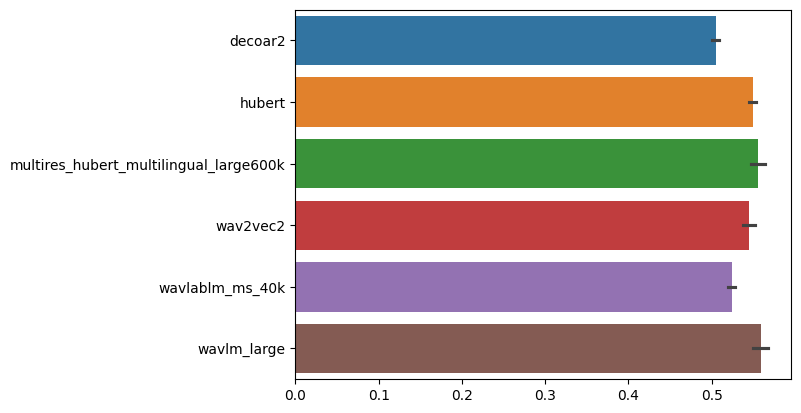

In [160]:
df.mean(axis=0).loc[:,:, metric_list].to_frame().unstack(1)

0             \
                         decoar2     hubert   
dev  loss              30.675427  22.696769   
     global-per         0.253404   0.188087   
     global-precision   0.366293   0.459708   
     global-f1-score    0.494659   0.557227   
test loss              28.084256  21.566428   
     global-per         0.234380   0.176798   
     global-precision   0.388103   0.478712   
     global-f1-score    0.505515   0.549612   

                                                                         \
                      multires_hubert_multilingual_large600k   wav2vec2   
dev  loss                                          21.822116  21.826117   
     global-per                                     0.183974   0.186787   
     global-precision                               0.465881   0.462039   
     global-f1-score                                0.566346   0.551991   
test loss                                          20.326308  20.711362   
     global-per                                     0.166294   0.175535   
     global-precision                               0.493667   0.479525   
     global-f1-score                                0.555624   0.544286   

                                                   
                      wavlablm_ms_40k wavlm_large  
dev  loss                   27.072842   18.949258  
     global-per              0.206713    0.159659  
     global-precision        0.427497    0.508201  
     global-f1-score         0.543937    0.591297  
test loss                   25.639354   18.600089  
     global-per              0.193061    0.155776  
     global-precision        0.437615    0.513392  
     global-f1-score         0.523932    0.559185

In [161]:

df.std(axis=0).loc[:,:, metric_list].to_frame().unstack(1)

0            \
                        decoar2    hubert   
dev  loss              0.274693  0.515960   
     global-per        0.004743  0.005330   
     global-precision  0.004225  0.008108   
     global-f1-score   0.004287  0.006780   
test loss              0.140122  0.466997   
     global-per        0.002938  0.003456   
     global-precision  0.002507  0.005639   
     global-f1-score   0.005850  0.005115   

                                                                        \
                      multires_hubert_multilingual_large600k  wav2vec2   
dev  loss                                           0.307304  0.322833   
     global-per                                     0.003132  0.002662   
     global-precision                               0.006254  0.006549   
     global-f1-score                                0.009799  0.006490   
test loss                                           0.297664  0.391249   
     global-per                                     0.002066  0.001943   
     global-precision                               0.004385  0.007089   
     global-f1-score                                0.010293  0.008671   

                                                   
                      wavlablm_ms_40k wavlm_large  
dev  loss                    0.641043    1.143801  
     global-per              0.002847    0.003309  
     global-precision        0.004037    0.010841  
     global-f1-score         0.004192    0.004904  
test loss                    0.517550    1.482766  
     global-per              0.000741    0.002652  
     global-precision        0.003157    0.009429  
     global-f1-score         0.005524    0.011325

In [162]:
df.std(axis=0).loc[:,:, metric_list].to_frame().unstack(1)

0            \
                        decoar2    hubert   
dev  loss              0.274693  0.515960   
     global-per        0.004743  0.005330   
     global-precision  0.004225  0.008108   
     global-f1-score   0.004287  0.006780   
test loss              0.140122  0.466997   
     global-per        0.002938  0.003456   
     global-precision  0.002507  0.005639   
     global-f1-score   0.005850  0.005115   

                                                                        \
                      multires_hubert_multilingual_large600k  wav2vec2   
dev  loss                                           0.307304  0.322833   
     global-per                                     0.003132  0.002662   
     global-precision                               0.006254  0.006549   
     global-f1-score                                0.009799  0.006490   
test loss                                           0.297664  0.391249   
     global-per                                     0.002066  0.001943   
     global-precision                               0.004385  0.007089   
     global-f1-score                                0.010293  0.008671   

                                                   
                      wavlablm_ms_40k wavlm_large  
dev  loss                    0.641043    1.143801  
     global-per              0.002847    0.003309  
     global-precision        0.004037    0.010841  
     global-f1-score         0.004192    0.004904  
test loss                    0.517550    1.482766  
     global-per              0.000741    0.002652  
     global-precision        0.003157    0.009429  
     global-f1-score         0.005524    0.011325

In [163]:
res_df
# res_df.loc(axis=1)['test', :, 'pvalue']

test                           \
                                                loss               global-per   
                                              pvalue  statistic        pvalue   
decoar2                                 1.792960e-10 -39.670248  2.893930e-10   
multires_hubert_multilingual_large600k  1.179799e-01   1.751407  8.508491e-05   
hubert                                  1.383939e-02  -3.138363  4.964210e-01   
wavlm_large                             1.515102e-02   3.078513  9.000740e-07   
wavlablm_ms_40k                         1.465723e-07 -16.984331  6.497526e-08   

                                                                               \
                                                  global-precision              
                                        statistic           pvalue  statistic   
decoar2                                -37.355018     3.610289e-09  27.186629   
multires_hubert_multilingual_large600k   7.285354     5.281975e-03  -3.793953   
hubert                                  -0.712476     8.460781e-01   0.200520   
wavlm_large                             13.439868     2.048527e-04  -6.419425   
wavlablm_ms_40k                        -18.845363     2.042964e-06  12.076131   

                                                                  \
                                       global-f1-score             
                                                pvalue statistic   
decoar2                                       0.000034  8.288665   
multires_hubert_multilingual_large600k        0.096356 -1.883698   
hubert                                        0.270811 -1.182892   
wavlm_large                                   0.047729 -2.335784   
wavlablm_ms_40k                               0.002206  4.427015   

                                                 dev                           \
                                                loss               global-per   
                                              pvalue  statistic        pvalue   
decoar2                                 4.901216e-11 -46.681856  3.403804e-09   
multires_hubert_multilingual_large600k  9.844792e-01   0.020070  1.644384e-01   
hubert                                  1.263704e-02  -3.198699  6.387065e-01   
wavlm_large                             6.363550e-04   5.412638  5.624164e-07   
wavlablm_ms_40k                         1.976304e-07 -16.345693  3.100872e-06   

                                                                               \
                                                  global-precision              
                                        statistic           pvalue  statistic   
decoar2                                -27.389458     3.323772e-09  27.471821   
multires_hubert_multilingual_large600k   1.530441     3.705472e-01  -0.948700   
hubert                                  -0.487906     6.304522e-01   0.500125   
wavlm_large                             14.284898     3.820733e-05  -8.149582   
wavlablm_ms_40k                        -11.431377     8.236792e-06  10.040338   

                                                                   
                                       global-f1-score             
                                                pvalue  statistic  
decoar2                                   1.853121e-07  16.481252  
multires_hubert_multilingual_large600k    2.580948e-02  -2.730909  
hubert                                    2.475504e-01  -1.247336  
wavlm_large                               4.749004e-06 -10.804791  
wavlablm_ms_40k                           4.807398e-02   2.331168

In [164]:
import re
latex = res_df.loc(axis=1)['test', :, 'pvalue'].sort_values(by=('test', 'global-precision', 'pvalue')).to_latex(float_format="%.2E")

latex = re.sub(
    r"(\d*)(\d).(\d)\d+E-01",
    r"\1.\2\3",
    latex
)

# latex = re.sub(
#     r"(\d*)(\d\d).\d+E-02",
#     r"\1.\2",
#     latex
# )

latex = re.sub(
    r"E(-\d+)",
    r"\\cdot 10^{\1}",
    latex
)

latex = latex.replace(' .', ' 0.') 


print(latex)

\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{4}{r}{test} \\
 & loss & global-per & global-precision & global-f1-score \\
 & pvalue & pvalue & pvalue & pvalue \\
\midrule
decoar2 & 1.79\cdot 10^{-10} & 2.89\cdot 10^{-10} & 3.61\cdot 10^{-09} & 3.38\cdot 10^{-05} \\
wavlablm_ms_40k & 1.47\cdot 10^{-07} & 6.50\cdot 10^{-08} & 2.04\cdot 10^{-06} & 2.21\cdot 10^{-03} \\
wavlm_large & 1.52\cdot 10^{-02} & 9.00\cdot 10^{-07} & 2.05\cdot 10^{-04} & 4.77\cdot 10^{-02} \\
multires_hubert_multilingual_large600k & 0.11 & 8.51\cdot 10^{-05} & 5.28\cdot 10^{-03} & 9.64\cdot 10^{-02} \\
hubert & 1.38\cdot 10^{-02} & 0.49 & 0.84 & 0.27 \\
\bottomrule
\end{tabular}



In [165]:
models

['wav2vec2',
 'wavlm_large',
 'multires_hubert_multilingual_large600k',
 'wavlablm_ms_40k',
 'hubert',
 'decoar2']

In [166]:
name_map = {x: x for x in models}

name_map.update({
    "hubert": 'HuBERT \\cite{hsu2021hubert}',
    "wav2vec2": 'Wav2Vec2 \\cite{baevski2020wav2vec}',
    "wavlablm_ms_40k": 'WavLabLM \\cite{wavlablm}',
    "wavlm_large": 'WavLM large \\cite{wavlm}',
    "wavlm_base_plus": 'WavLM \\cite{wavlm}',
    "decoar2": 'DeCoAR 2.0 \\cite{decoar2}',
    "multires_hubert_multilingual_base": 'MR-HuBERT \\cite{multires-hubert}',
    "multires_hubert_multilingual_large600k": 'MR-HuBERT large (600k steps) \\cite{multires-hubert}',
    "multires_hubert_multilingual_large400k": 'MR-HuBERT large (400k steps) \\cite{multires-hubert}',
})

In [167]:
metric_map = {x: x for x in metric_list}

metric_map.update({
    'loss': 'Loss',
    'global-per': 'PER',
    'global-f1-score': "F1-score",
    'global-precision': "Precision",
})

In [168]:
dfmean = df['test'].mean().loc[:, metric_list].unstack(1).sort_values(by='global-f1-score').round(3)
dfstd = df['test'].std().loc[:, metric_list].unstack(1).sort_values(by='global-f1-score').round(3)
dfmean.iloc(axis=1)[0] = dfmean.iloc(axis=1)[0].round(2)
dfstd.iloc(axis=1)[0] = dfstd.iloc(axis=1)[0].round(2)

dfx = ("$" + dfmean.astype(str) + "\pm " + dfstd.astype(str) + "$")

dfx.index = dfx.index.to_series().map(name_map)
dfx.columns = dfx.columns.to_series().map(metric_map)

latex = dfx.to_latex().replace('_', '\_').replace('lllll', 'lrrrr')

# import re
# latex = res_df.loc(axis=1)['test', :, 'pvalue'].sort_values(by=('test', 'global-precision', 'pvalue')).to_latex(float_format="%.2E")

# latex = re.sub(
#     r"(\d*)(\d).(\d)\d+E-01",
#     r"\1.\2\3",
#     latex
# )

# # latex = re.sub(
# #     r"(\d*)(\d\d).\d+E-02",
# #     r"\1.\2",
# #     latex
# # )

# latex = re.sub(
#     r"E(-\d+)",
#     r"\\cdot 10^{\1}",
#     latex
# )

# latex = latex.replace(' .', ' 0.') 


print(latex)

\begin{tabular}{lrrrr}
\toprule
 & Loss & PER & Precision & F1-score \\
\midrule
DeCoAR 2.0 \cite{decoar2} & $28.08\pm 0.14$ & $0.234\pm 0.003$ & $0.388\pm 0.003$ & $0.506\pm 0.006$ \\
HuBERT \cite{hsu2021hubert} & $21.57\pm 0.47$ & $0.177\pm 0.003$ & $0.479\pm 0.006$ & $0.55\pm 0.005$ \\
MR-HuBERT large (600k steps) \cite{multires-hubert} & $20.33\pm 0.3$ & $0.166\pm 0.002$ & $0.494\pm 0.004$ & $0.556\pm 0.01$ \\
Wav2Vec2 \cite{baevski2020wav2vec} & $20.71\pm 0.39$ & $0.176\pm 0.002$ & $0.48\pm 0.007$ & $0.544\pm 0.009$ \\
WavLabLM \cite{wavlablm} & $25.64\pm 0.52$ & $0.193\pm 0.001$ & $0.438\pm 0.003$ & $0.524\pm 0.006$ \\
WavLM large \cite{wavlm} & $18.6\pm 1.48$ & $0.156\pm 0.003$ & $0.513\pm 0.009$ & $0.559\pm 0.011$ \\
\bottomrule
\end{tabular}



In [169]:

pd.DataFrame(results, index=small_augs, columns=pd.MultiIndex.from_product([splits, metric_list, ['pvalue', 'statistic']])).loc(axis=1)[:, :, 'statistic'].style.highlight_between(color='green', right=-2)

In [182]:
name_map

{'wav2vec2': 'Wav2Vec2 \\cite{baevski2020wav2vec}',
 'wavlm_large': 'WavLM large \\cite{wavlm}',
 'multires_hubert_multilingual_large600k': 'MR-HuBERT large (600k steps) \\cite{multires-hubert}',
 'wavlablm_ms_40k': 'WavLabLM \\cite{wavlablm}',
 'hubert': 'HuBERT \\cite{hsu2021hubert}',
 'decoar2': 'DeCoAR 2.0 \\cite{decoar2}',
 'wavlm_base_plus': 'WavLM \\cite{wavlm}',
 'multires_hubert_multilingual_base': 'MR-HuBERT \\cite{multires-hubert}',
 'multires_hubert_multilingual_large400k': 'MR-HuBERT large (400k steps) \\cite{multires-hubert}'}

In [198]:
dfx.mean().sort_values()

DeCoAR 2.0                      0.505515
WavLabLM                        0.523932
Wav2Vec2                        0.544286
HuBERT                          0.549612
MR-HuBERT large (600k steps)    0.555624
WavLM large                     0.559185
dtype: float64

In [207]:
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)

In [222]:

sns.set_theme(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1.5, color_codes=False, rc=None)

/tmp/ipykernel_151394/1904323493.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, rotation=0)
/tmp/ipykernel_151394/1904323493.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, rotation=0)


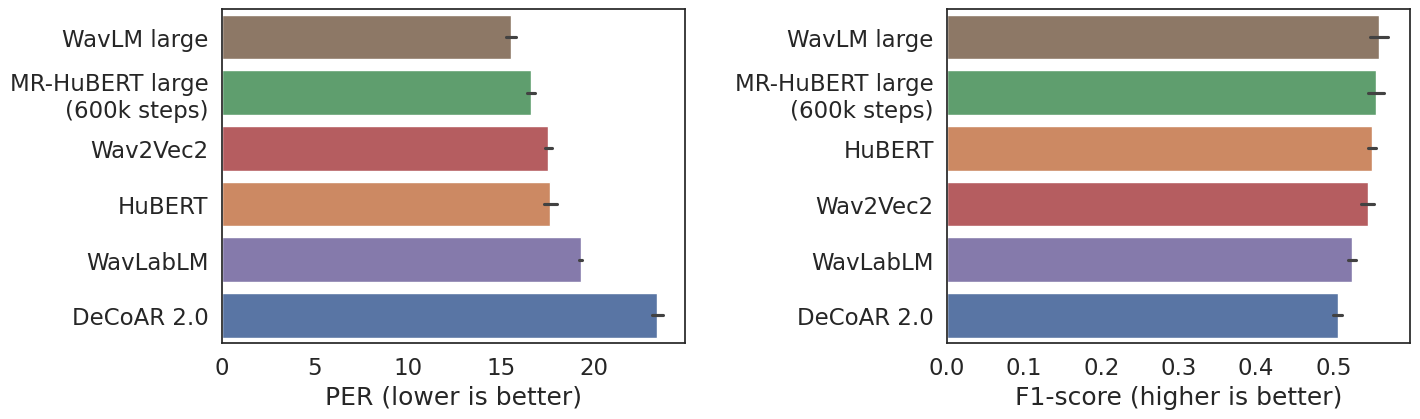

In [227]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


dfx =df['test'].swaplevel(axis=1)['global-per'] * 100
dfx.columns = dfx.columns.to_series().map({k: v.split('\\', 1)[0].strip() for k,v  in name_map.items()}).values
axis = sns.barplot(dfx, orient='y', errorbar='sd', order=dfx.mean().sort_values(ascending=True).index, ax=ax[0])
axis.set_xlabel('PER (lower is better)')
wrap_labels(axis, 15)

dfx =df['test'].swaplevel(axis=1)['global-f1-score']
dfx.columns = dfx.columns.to_series().map({k: v.split('\\', 1)[0].strip() for k,v  in name_map.items()}).values
axis = sns.barplot(dfx, orient='y', errorbar='sd', order=dfx.mean().sort_values(ascending=False).index, ax=ax[1])
axis.set_xlabel('F1-score (higher is better)')
wrap_labels(axis, 15)

plt.tight_layout(pad=2)

In [170]:
history['dev_f1_score']

NameError: name 'history' is not defined

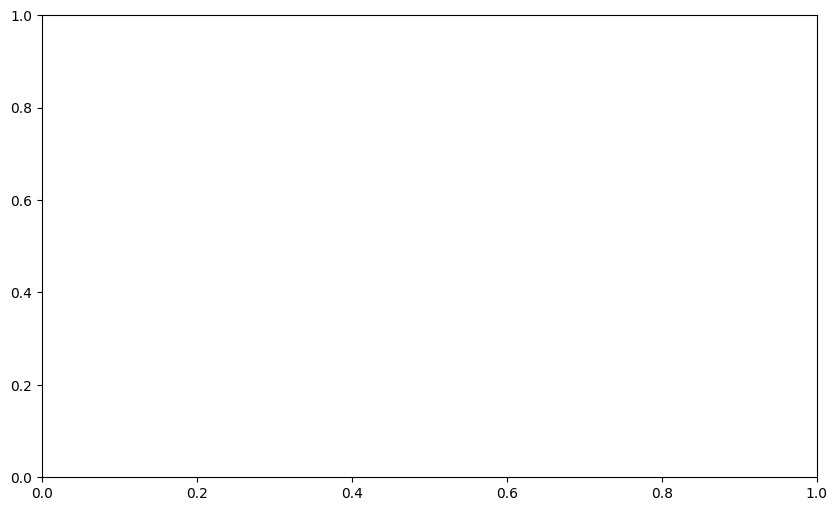

In [171]:
fig, ax = plt.subplots(figsize=(10, 6))
histories = [
            history[f"{split}_f1_score"][aug]
            .reset_index(drop=True)
            .rename(columns=lambda col: f"{aug} | {split}")
            .rename_axis(index="epoch", columns='f1 score')
    for split in ['dev', 'test']
    for aug in models
]

sns.lineplot(
            pd.concat(histories, axis=1),
            errorbar="sd",
            palette='colorblind'
        ).set(ylabel='f1 score',
xticks=list(range(0, 20, 2)))

plt.savefig('f1_scores.png')

# plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [ ]:
scipy.stats.ttest_ind(
    history['test_f1_score']['phase_perturbation'].iloc[3],
    history['test_f1_score']['phase_perturbation'].iloc[15],
)

In [ ]:
history['test_f1_score']['phase_perturbation'].iloc[3]

In [ ]:
history['test_f1_score']['phase_perturbation'].iloc[19]